In [118]:
import os
import ast
import numpy as np
import pandas as pd
from scipy import stats
import sklearn
import matplotlib.pyplot as plt
import librosa
import librosa.display

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 5)

In [119]:
from google.colab import drive
drive.mount('data')

Drive already mounted at data; to attempt to forcibly remount, call drive.mount("data", force_remount=True).


In [120]:
def load(filepath):
  filename = os.path.basename(filepath)

  if 'features' in filename:
    return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])
  
  if 'echonest' in filename:
    return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

  if 'genres' in filename:
    return pd.read_csv(filepath, index_col=0)

  if 'tracks' in filename:
    tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

    COLUMNS = [('track', 'tags'),
               ('album', 'tags'),
               ('artist', 'tags'),
               ('track', 'genres'),
               ('track', 'genres_all')]

    for column in COLUMNS:
      tracks[column] = tracks[column].map(ast.literal_eval)

    COLUMNS = [('track', 'date_created'),
               ('track', 'date_recorded'),
               ('album', 'date_created'),
               ('album', 'date_released'),
               ('artist', 'date_created'),
               ('artist', 'active_year_begin'),
               ('artist', 'active_year_end')]

    for column in COLUMNS:
      tracks[column] = pd.to_datetime(tracks[column])

    SUBSETS = ('small', 'medium', 'large')

    tracks['set', 'subset'] = tracks['set', 'subset'].astype(pd.CategoricalDtype(categories=SUBSETS, ordered=True))

    COLUMNS = [('track', 'genre_top'),
               ('track', 'license'),
               ('album', 'type'),
               ('album', 'information'),
               ('artist', 'bio')]

    for column in COLUMNS:
      tracks[column] = tracks[column].astype('category')

    return tracks

In [121]:
def get_audio_path(audio_dir, track_id):
  tid_str = '{:06d}'.format(track_id)
  return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')

In [122]:
def get_fs_tids(audio_dir):
  tids = []
  for _, dirnames, files in os.walk(audio_dir):
    if dirnames == []:
      tids.extend(int(file[:-4]) for file in files)
  return tids

In [123]:
AUDIO_DIR = os.path.abspath('/content/data/MyDrive/data/fma_small')
tracks = load('/content/data/MyDrive/data/fma_metadata/tracks.csv')
# genres = load('/content/data/MyDrive/data/fma_metadata/genres.csv')
features = load('/content/data/MyDrive/data/fma_metadata/features.csv')
# echonest = load('/content/data/MyDrive/data/fma_metadata/echonest.csv')

In [124]:
columns = [('set', 'split'), ('set', 'subset'), ('track', 'genre_top'), ('track', 'genres')]
tracks = tracks[columns]
small = tracks[tracks['set', 'subset'] <= 'small']
small.shape

(8000, 4)

In [125]:
small[('set', 'split')].value_counts()

training      6400
validation     800
test           800
Name: (set, split), dtype: int64

In [126]:
small[('track', 'genre_top')].value_counts()

Rock                   1000
Pop                    1000
International          1000
Instrumental           1000
Hip-Hop                1000
Folk                   1000
Experimental           1000
Electronic             1000
Spoken                    0
Soul-RnB                  0
Old-Time / Historic       0
Jazz                      0
Easy Listening            0
Country                   0
Classical                 0
Blues                     0
Name: (track, genre_top), dtype: int64

In [127]:
chroma_cens = features['chroma_cens']
chroma_cqt = features['chroma_cqt']
chroma_stft = features['chroma_stft']
mfcc = features['mfcc']
rmse = features['rmse']
spectral_bandwidth = features['spectral_bandwidth']
spectral_centroid = features['spectral_centroid']
spectral_contrast = features['spectral_contrast']
spectral_rolloff = features['spectral_rolloff']
tonnetz = features['tonnetz']
zcr = features['zcr']

In [128]:
rock = tracks['track', 'genre_top'] == 'Rock'
pop = tracks['track', 'genre_top'] == 'Pop'
international = tracks['track', 'genre_top'] == 'International'
instrumental = tracks['track', 'genre_top'] == 'Instrumental'
hip_hop = tracks['track', 'genre_top'] == 'Hip-Hop'
folk = tracks['track', 'genre_top'] == 'Folk'
experimental = tracks['track', 'genre_top'] == 'Experimental'
electronic = tracks['track', 'genre_top'] == 'Electronic'

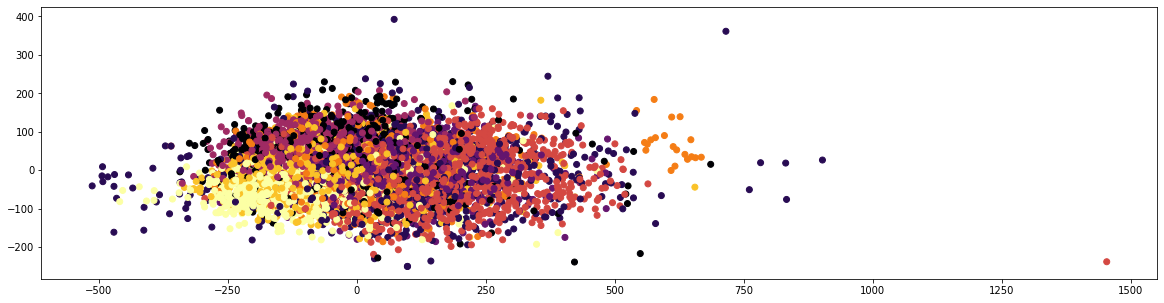

In [129]:
small = tracks['set', 'subset'] <= 'small'

X = features.loc[small & (rock | pop | international | instrumental | hip_hop | folk | experimental | electronic), 'mfcc']
X = sklearn.decomposition.PCA().fit_transform(X)
y = tracks.loc[small & (rock | pop | international | instrumental | hip_hop | folk | experimental | electronic), ('track', 'genre_top')]
y = sklearn.preprocessing.LabelEncoder().fit_transform(y)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='inferno')
plt.show()

In [130]:
small = tracks['set', 'subset'] <= 'small'

training = tracks['set', 'split'] == 'training'
test = tracks['set', 'split'] == 'test'
validation = tracks['set', 'split'] == 'validation'

X_train = features.loc[small & training, 'mfcc']
X_validation = features.loc[small & validation, 'mfcc']
X_test = features.loc[small & test, 'mfcc']

y_train = tracks.loc[small & training, ('track', 'genre_top')]
y_validation = tracks.loc[small & validation, ('track', 'genre_top')]
y_test = tracks.loc[small & test, ('track', 'genre_top')]

In [131]:
X_train, y_train = sklearn.utils.shuffle(X_train, y_train, random_state=42)
scaler = sklearn.preprocessing.StandardScaler(copy=False)
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

le = sklearn.preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_validation = le.transform(y_validation)
y_test = le.transform(y_test)

neigh = sklearn.neighbors.NearestNeighbors(n_neighbors=10)
neigh.fit(X_train)
distances, indices = neigh.kneighbors(X_test)

# neigh = sklearn.neighbors.KNeighborsClassifier(n_neighbors=10)
# neigh.fit(X_train, y_train)
# y_pred = neigh.predict(X_test)

# score = neigh.score(X_test, y_test)
# y_pred = neigh.predict(X_test)

In [ ]:
filename = '/content/data/MyDrive/data/fma_small/000/000002.mp3'

y, sr = librosa.load(filename, sr=None, mono=True)

stft = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)

moments = ('mean', 'std', 'skew', 'kurtosis', 'median', 'min', 'max')

columns = []
for moment in moments:
  it = (('mfcc', moment, '{:02d}'.format(i + 1)) for i in range(20))
  columns.extend(it)

names = ('feature', 'statistics', 'number')
columns = pd.MultiIndex.from_tuples(columns, names=names)
columns = columns.sort_values()
feature = pd.Series(index=columns, dtype=np.float32)

feature['mfcc', 'mean'] = np.mean(mfcc, axis=1)
feature['mfcc', 'std'] = np.std(mfcc, axis=1)
feature['mfcc', 'skew'] = stats.skew(mfcc, axis=1)
feature['mfcc', 'kurtosis'] = stats.kurtosis(mfcc, axis=1)
feature['mfcc', 'median'] = np.median(mfcc, axis=1)
feature['mfcc', 'min'] = np.min(mfcc, axis=1)
feature['mfcc', 'max'] = np.max(mfcc, axis=1)

feature = feature['mfcc'].values.reshape(1, 140)
feature = sklearn.preprocessing.StandardScaler().fit_transform(feature)

distances, indices = neigh.kneighbors(feature)